## DL Class Project

I have used the SIFT, SURF, ORB, ArcFace, and AKAZE algorithms for matching images. Image Preprocessing (CLAHE) was performed before applying the matching algorithms. A genuine-imposter histogram was plotted for each algorithm. The generated genuine and histogram datasets were used to plot the receiver operating characteristic (ROC) curve of FRR (X-Axis) vs FRR (Y-Axis). Correct Recognition Rate (CRR) and Equal Error Rate (EER) were calculated from the resulting ROC curve.

In [ ]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
from natsort import natsorted
import random

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, for each image, we are going to generate the SIFT features. First, we have to construct a SIFT object and then use the function detectAndCompute to get the keypoints. It will return two values – the keypoints and the descriptors. Next, match the features of each possible pair of images using match() from the BFmatcher (brute force match) module.



In [ ]:
# NECESSARY:

!pip install opencv-python
!pip install opencv-contrib-python

In [ ]:
def clip_matching_scores(file_path, max_score = 1.0):
    df = pd.read_csv(file_path, delimiter=' ', header=None)
    df['2'][df['2'] >= max_score] = max_score
    return df

def generate_genuine_imposter(file_path, min_score = 0.0, max_score = 20.0):
    df = pd.read_csv(file_path, delimiter=' ', header=None)
    # df = pd.read_csv(file_path, header=None)
    df.drop_duplicates(keep='first',inplace=True)

    # df = clip_matching_scores(file1_path, max_score = 1.0)

    # max_score = 1.0
    # df[2][df[2] >= max_score] = max_score

    genuine = []
    imposter = []
    for i in range(len(df[0])):
        
        person1 = df[0][i].split("_")
        person2 = df[1][i].split("_")
        
        if df[2][i] > min_score and df[2][i] < max_score:
            if person1[0] == person2[0]:
                genuine.append(round(df[2][i], 2))
            else:
                imposter.append(round(df[2][i], 2))
    
    return genuine, imposter

def return_dict_from_lists(genuine, imposter):

    gen_freq = [(x, genuine.count(x)) for x in set(genuine)]
    imp_freq = [(x, imposter.count(x)) for x in set(imposter)]

    gen_freq = dict(gen_freq)
    imp_freq = dict(imp_freq)

    gen_freq = {k: v / total for total in (sum(gen_freq.values()),) for k, v in gen_freq.items()}
    imp_freq = {k: v / total for total in (sum(imp_freq.values()),) for k, v in imp_freq.items()}

    return gen_freq, imp_freq

def plot_hist_from_dict(genuine, imposter, name):
    path = "/home/srujan/BITS/DL/Class_Project"

    gen_lists = sorted(genuine.items())
    x, y = zip(*gen_lists)
    y = [i*100 for i in y]
    # plt.plot(x,y, color='g')
    plt.xlabel('Macthing Score')
    plt.ylabel('Probability')
    # plt.title('Genuine Histogram')
    # plt.fill_between(x, y, color="green", alpha=0.5)
    plt.grid(True)
    plt.hist(x, weights=y, bins=np.linspace(0, max(x), 100))
    # plt.show()
    # plt.savefig('/'+name+'_genuine.png')
    # plt.close()

    imp_lists = sorted(imposter.items())
    x, y = zip(*imp_lists)
    y = [i*100 for i in y]
    # plt.plot(x,y, color='r')
    plt.hist(x, weights=y, bins=np.linspace(0, max(x), 100), alpha=0.7)
    # plt.xlabel('Macthing Score')
    # plt.ylabel('Probability')
    plt.title('Genuine Imposter Histogram')
    # plt.fill_between(x, y, color="red", alpha=0.5)
    plt.grid(True)
    plt.legend(['Genuine', 'Imposter'])
    plt.savefig(path+'/'+name+'_hist_histogram.png')
    plt.show()
    plt.close()

In [ ]:
def get_frr_far(genuine, imposter, threshold):
    far = len([x for x in imposter if x >= threshold])/len(imposter)
    frr = len([x for x in genuine if x < threshold])/len(genuine)
    return far*100, frr*100 # rate in %

def plot_ROC(genuine, imposter, name):
    
    path = "/home/srujan/BITS/DL/Class_Project"

    FAR = []
    FRR = []
    threshold = None
    final_far = None
    final_frr = None
   
    min_dist = 1e5
    for t in np.linspace(0, 2, 1000):
        far, frr = get_frr_far(genuine, imposter, t)
        FAR.append(far)
        FRR.append(frr)

        if abs(far - frr) < min_dist:
            threshold = t
            min_dist = abs(far - frr)
            final_far = far
            final_frr = frr
           
 
    plt.plot(FAR, FRR)  # plot ROC
    plt.xlabel("FRR (%)")
    plt.ylabel("FAR (%)")
    plt.title("ROC Curve")
    plt.plot(np.linspace(0,100,100), np.linspace(0,100,100), '--')  # y = x line
    plt.legend(["ROC", "y=x"])
    plt.savefig(path+'/'+name+'.png')
    print(f"threshold is {threshold}")
    return final_far, final_frr, threshold

In [ ]:
def get_CRR(genuine, imposter, threshold, name):
    # file1 = open("/home/srujan/BITS/DL/Class_Project/CRR/"+name+'.txt', 'w')
    TP = len([x for x in genuine if x > threshold])
    TN = len([x for x in imposter if x <= threshold])
    CRR = (TP + TN) / (len(genuine) + len(imposter))
    CRR = CRR * 100 # %
    print(f"CRR is {CRR:0.3f}% at threshold {threshold:0.3f}")
    # file1.write(f"CRR is {CRR:0.5f} at threshold {threshold:0.3f}\n")
    # file1.close()
    return CRR

def get_EER(far, frr, threshold, name):
    # file1 = open("/home/srujan/BITS/DL/Class_Project/EER/"+name+'.txt', 'w')
    EER = (far+frr)/2.
    print(f"EER is {EER:0.3f}% at threshold {threshold:0.3f}")
    # file1.write(f"EER is {EER:0.3f} at threshold {threshold:0.3f}\n")
    # file1.close()
    return EER

def get_Acurracy(far, frr, threshold, name):
    # file1 = open("/home/srujan/BITS/DL/Class_Project/Accuracy/"+name+'.txt', 'w')
    Accuracy = 100 - (far+frr)/2.
    print(f"Accuracy is {Accuracy:0.3f}% at threshold {threshold:0.3f}")
    # file1.write(f"Accuracy is {Accuracy:0.3f} at threshold {threshold:0.3f}\n")
    # file1.close()
    return Accuracy

### SIFT MATCHING

In [ ]:
from tqdm import tqdm

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/max_sift.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

lowe = 0.7 # Change this to 0.8, 0.9 for ablation study
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L2)
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    kp1, des1 = sift.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    kp2, des2 = sift.detectAndCompute(img2,None)
                # Initiate SIFT detector
                #sift = cv2.SIFT()            
                # find the keypoints and descriptors with SIFT
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < lowe*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                # if (img1_split[0] == img2_split[0]):
                #     genuine.append(round(float(score), 3))
                # else:
                #     imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

819  is genuine length
11428  is imposter lenght


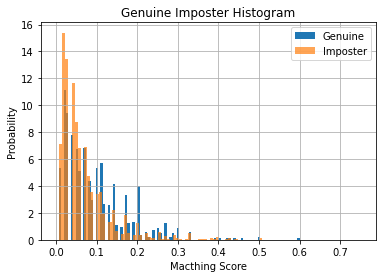

threshold is 0.050050050050050046
CRR is 56.634% at threshold 0.050
EER is 41.996% at threshold 0.050
Accuracy is 58.004% at threshold 0.050


58.003840362958314

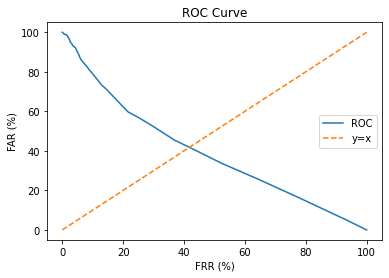

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/max_sift.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)

print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'max_sift')
far, frr, threshold = plot_ROC(genuine, imposter, 'max_sift')
get_CRR(genuine, imposter, threshold, 'max_sift')
get_EER(far,frr,threshold, 'max_sift')
get_Acurracy(far,frr,threshold, 'max_sift')

## **SURF**

### SURF MATCHING

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/max_surf.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

lowe = 0.7 # Change this to 0.8, 0.9 for ablation study
surf = cv2.xfeatures2d.SURF_create()
bf = cv2.BFMatcher(cv2.NORM_L2)
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    kp1, des1 = surf.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    kp2, des2 = surf.detectAndCompute(img2,None)
                # Initiate SIFT detector
                #sift = cv2.SIFT()            
                # find the keypoints and descriptors with SIFT
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < lowe*n.distance:
                                good.append([m])
                    except:
                        # print(matches)
                        continue
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

100%|██████████| 336/336 [20:27<00:00,  3.65s/it]


1561  is genuine length
32753  is imposter lenght


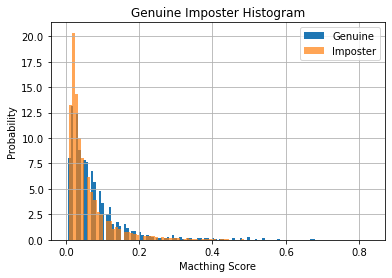

threshold is 0.04004004004004004
CRR is 57.898% at threshold 0.040
EER is 42.279% at threshold 0.040
Accuracy is 57.721% at threshold 0.040


57.7212658026465

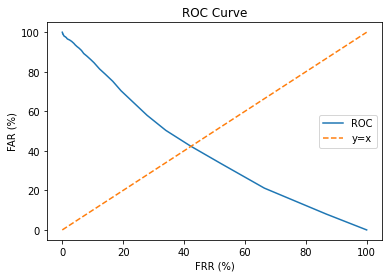

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/max_surf.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)

print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'max_surf')
far, frr, threshold = plot_ROC(genuine, imposter, 'max_surf')
get_CRR(genuine, imposter, threshold, 'max_surf')
get_EER(far,frr,threshold, 'max_surf')
get_Acurracy(far,frr,threshold, 'max_surf')

### **SURF** GENUINE, IMPOSTER HISTOGRAMS, ROC, EER, CRR

# ORB

### ORB Matching

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/orb.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    kp1, des1 = orb.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    kp2, des2 = orb.detectAndCompute(img2,None)
                # Initiate orb detector
                #orb = cv2.orb()            
                # find the keypoints and descriptors with orb
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < 0.7*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

100%|██████████| 336/336 [00:50<00:00,  6.59it/s]


158  is genuine length
1943  is imposter lenght


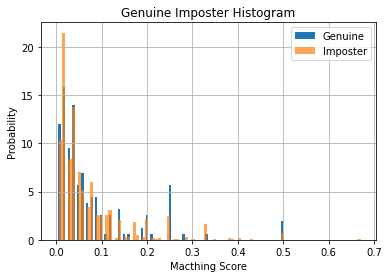

threshold is 0.04004004004004004
CRR is 53.546% at threshold 0.040
EER is 48.664% at threshold 0.040
Accuracy is 51.336% at threshold 0.040


51.33569385720894

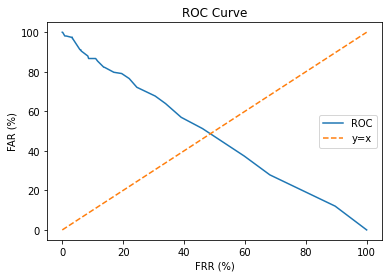

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/max_orb.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)
print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'max_orb')
far, frr, threshold = plot_ROC(genuine, imposter, 'max_orb')
get_CRR(genuine, imposter, threshold, 'max_orb')
get_EER(far,frr,threshold, 'max_orb')
get_Acurracy(far,frr,threshold, 'max_orb')

### ORB NFeatures=10000

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/max_orb_10000.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    kp1, des1 = orb.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    kp2, des2 = orb.detectAndCompute(img2,None)
                # Initiate orb detector
                #orb = cv2.orb()            
                # find the keypoints and descriptors with orb
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < 0.7*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

100%|██████████| 336/336 [00:49<00:00,  6.77it/s]


261  is genuine length
3713  is imposter lenght


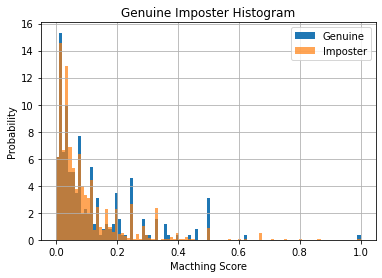

threshold is 0.06006006006006006
CRR is 52.391% at threshold 0.060
EER is 47.741% at threshold 0.060
Accuracy is 52.259% at threshold 0.060


52.2588647322806

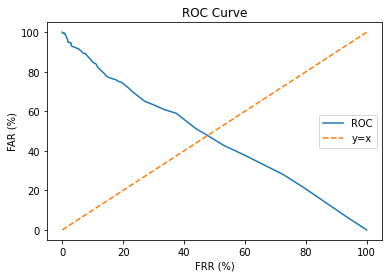

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/max_orb_10000.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)
print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'max_orb_10000')
far, frr, threshold = plot_ROC(genuine, imposter, 'max_orb_10000')
get_CRR(genuine, imposter, threshold, 'max_orb_10000')
get_EER(far,frr,threshold, 'max_orb_10000')
get_Acurracy(far,frr,threshold, 'max_orb_10000')

### CLAHE ORB  

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/clahe_orb.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = clahe.apply(img1)
    kp1, des1 = orb.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
                    img2 = clahe.apply(img2)

                    kp2, des2 = orb.detectAndCompute(img2,None)
                # Initiate orb detector
                #orb = cv2.orb()            
                # find the keypoints and descriptors with orb
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < 0.7*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

100%|██████████| 336/336 [02:36<00:00,  2.15it/s]


837  is genuine length
16398  is imposter lenght


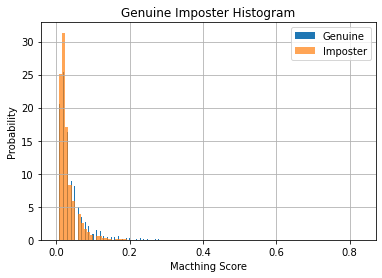

threshold is 0.02002002002002002
CRR is 56.252% at threshold 0.020
EER is 44.815% at threshold 0.020
Accuracy is 55.185% at threshold 0.020


55.18450978154955

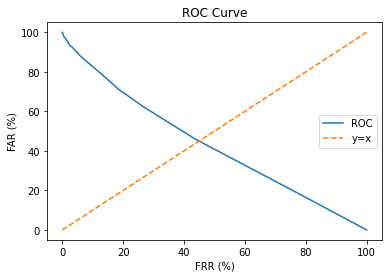

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/clahe_orb.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)
print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'clahe_orb')
far, frr, threshold = plot_ROC(genuine, imposter, 'clahe_orb')
get_CRR(genuine, imposter, threshold, 'clahe_orb')
get_EER(far,frr,threshold, 'clahe_orb')
get_Acurracy(far,frr,threshold, 'clahe_orb')

### CLAHE ORB NFeatures=10000

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/clahe_orb_10000.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
orb = cv2.ORB_create(10000)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = clahe.apply(img1)
    kp1, des1 = orb.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
                    img2 = clahe.apply(img2)

                    kp2, des2 = orb.detectAndCompute(img2,None)
                # Initiate orb detector
                #orb = cv2.orb()            
                # find the keypoints and descriptors with orb
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < 0.7*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

100%|██████████| 336/336 [02:45<00:00,  2.03it/s]


761  is genuine length
15634  is imposter lenght


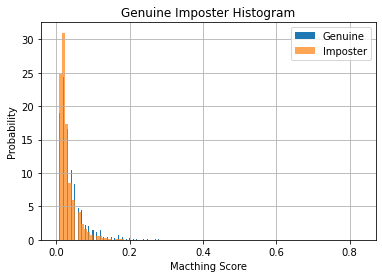

threshold is 0.02002002002002002
CRR is 55.810% at threshold 0.020
EER is 43.797% at threshold 0.020
Accuracy is 56.203% at threshold 0.020


56.202741018807856

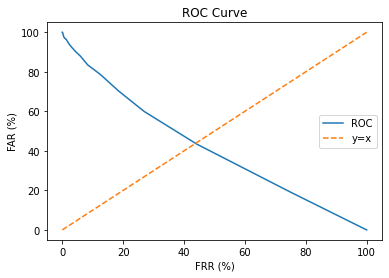

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/clahe_orb_10000.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)
print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'clahe_orb_10000')
far, frr, threshold = plot_ROC(genuine, imposter, 'clahe_orb_10000')
get_CRR(genuine, imposter, threshold, 'clahe_orb_10000')
get_EER(far,frr,threshold, 'clahe_orb_10000')
get_Acurracy(far,frr,threshold, 'clahe_orb_10000')

### **AKAZE**

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/akaze.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
akaze = cv2.AKAZE_create()
bf = cv2.BFMatcher()
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    kp1, des1 = akaze.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    kp2, des2 = akaze.detectAndCompute(img2,None)
                # Initiate akaze detector
                #akaze = cv2.akaze()            
                # find the keypoints and descriptors with akaze
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) <= len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < 0.7*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

  0%|          | 0/336 [00:00<?, ?it/s]/tmp/ipykernel_5751/1532681857.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (img1 != img2): # queryImage
100%|██████████| 336/336 [00:51<00:00,  6.56it/s]


2  is genuine length
24  is imposter lenght


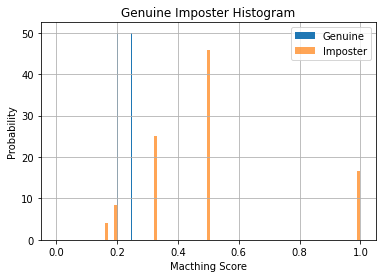

threshold is 0.2502502502502503
CRR is 11.538% at threshold 0.250
EER is 93.750% at threshold 0.250
Accuracy is 6.250% at threshold 0.250


6.25

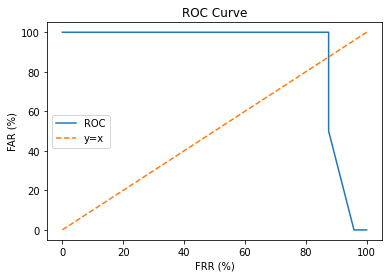

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/akaze.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)
print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'akaze')
far, frr, threshold = plot_ROC(genuine, imposter, 'akaze')
get_CRR(genuine, imposter, threshold, 'akaze')
get_EER(far,frr,threshold, 'akaze')
get_Acurracy(far,frr,threshold, 'akaze')

### **CLAHE AKAZE**

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/clahe_akaze.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
akaze = cv2.AKAZE_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = clahe.apply(img1)
    kp1, des1 = akaze.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
                    img2 = clahe.apply(img2)

                    kp2, des2 = akaze.detectAndCompute(img2,None)
                # Initiate akaze detector
                #akaze = cv2.akaze()            
                # find the keypoints and descriptors with akaze
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < 0.7*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

  0%|          | 0/336 [00:00<?, ?it/s]/tmp/ipykernel_5751/2618726940.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (img1 != img2): # queryImage
100%|██████████| 336/336 [03:54<00:00,  1.44it/s]


519  is genuine length
7214  is imposter lenght


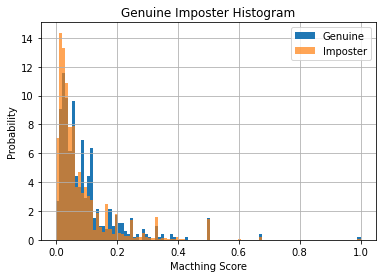

threshold is 0.050050050050050046
CRR is 53.938% at threshold 0.050
EER is 42.927% at threshold 0.050
Accuracy is 57.073% at threshold 0.050


57.07263173245343

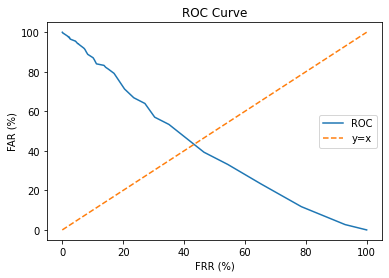

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/clahe_akaze.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=2.0)
print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'clahe_akaze')
far, frr, threshold = plot_ROC(genuine, imposter, 'clahe_akaze')
get_CRR(genuine, imposter, threshold, 'clahe_akaze')
get_EER(far,frr,threshold, 'clahe_akaze')
get_Acurracy(far,frr,threshold, 'clahe_akaze')

## **CLAHE SIFT:**

In [ ]:
from google.colab.patches import cv2_imshow # To print images in colab

In [ ]:
file1 = open("/home/srujan/BITS/DL/Class_Project/clahe_sift.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

lowe = 0.7 # Change this to 0.8, 0.9 for ablation study
genuine = []
imposter = []
sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L2)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    # cv2_imshow(img1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    img1 = clahe.apply(img1)
    # cv2_imshow(img1)
    kp1, des1 = sift.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
                    img2 = clahe.apply(img2)
                    
                    kp2, des2 = sift.detectAndCompute(img2,None)

                # Initiate SIFT detector
                #sift = cv2.SIFT()            
                # find the keypoints and descriptors with SIFT
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < lowe*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + "," + str2 + "," + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

### CLAHE SIFT GENUINE, IMPOSTER HISTOGRAMS, ROC, EER, CRR

1164  is genuine length
17831  is imposter lenght


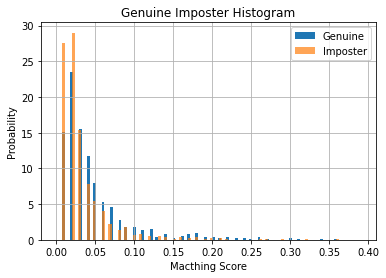

threshold is 0.02002002002002002
CRR is 56.825% at threshold 0.020
EER is 41.024% at threshold 0.020
Accuracy is 58.976% at threshold 0.020


58.97563483111096

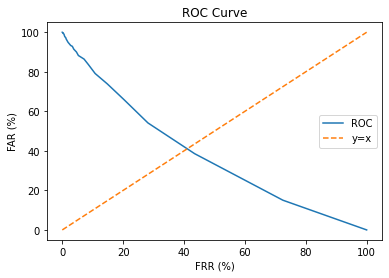

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/clahe_sift.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=0.4)

print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'clahe_sift')
far, frr, threshold = plot_ROC(genuine, imposter, 'clahe_sift')
get_CRR(genuine, imposter, threshold, 'clahe_sift')
get_EER(far,frr,threshold, 'clahe_sift')
get_Acurracy(far,frr,threshold, 'clahe_sift')

## **CLAHE SURF**

In [ ]:
# path1 = "/content/drive/My Drive/"
# temp_file = open("/home/srujan/BITS/DL/Class_Project/temp.txt", 'w')

lowe = 0.7 # Change this to 0.8, 0.9 for ablation study
file1 = open("/home/srujan/BITS/DL/Class_Project/clahe_surf_L2.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

genuine = []
imposter = []
surf = cv2.xfeatures2d.SURF_create()
bf = cv2.BFMatcher(cv2.NORM_L2)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
for images in tqdm(natsorted(os.listdir(path1))):
    str1 = str(images)
    img1 = os.path.join(path1, images)
    #print(img1)
    img1 = cv2.imread(img1)
    # cv2_imshow(img1)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    img1 = clahe.apply(img1)
    # cv2_imshow(img1)
    kp1, des1 = surf.detectAndCompute(img1,None)
    if len(kp1)>0:
       for image in natsorted(os.listdir(path1)):
            img2 = os.path.join(path1, image)
            # print(img2)
            str2 = str(image)
            img1_split = str1.split("_")
            img2_split = str2.split("_")
            if img1_split[2] != img2_split[2]:
                if (img1 != img2): # queryImage
                    img2 = cv2.imread(img2) # trainImage
                    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
                    img2 = clahe.apply(img2)
                    
                    kp2, des2 = surf.detectAndCompute(img2,None)

                # Initiate surf detector
                #sift = cv2.SIFT()            
                # find the keypoints and descriptors with SIFT
                # BFMatcher with default params
                
                # print(img1_split[2] != img2_split[2])
                if des2 is not None:
                    matches = bf.knnMatch(des1,des2, k=2)
                    dis = bf.match(des1,des2)
                #----------------------------------------------
                    number_keypoints = 0
                    if len(kp1) > len(kp2):
                        number_keypoints = len(kp1)
                    else:
                        number_keypoints = len(kp2)
                    good = []
                    try:
                        for m,n in matches:
                            if m.distance < lowe*n.distance:
                                good.append([m])
                    except:
                        continue
                        # print(matches)
                #print("Keypoints 1ST Image: " + str(len(kp1)))
                #print("Keypoints 2ND Image: " + str(len(kp2)))
                #print("GOOD Matches:", len(good))
                    score = len(good) / number_keypoints
                else:
                    score = 0.
                #print("How good it's the match: ", score) #* 100, "%")
                file1.write( str1 + " " + str2 + " " + str(score)+"\n")
                if (img1_split[0] == img2_split[0]):
                    genuine.append(round(float(score), 3))
                else:
                    imposter.append(round(float(score), 3))
                # print(str1 + " " + str2 + " " + str(score)) # replace with 'cos' if using cosine similarity
file1.close()

### **CLAHE SURF** GENUINE, IMPOSTER HISTOGRAMS, ROC, EER, CRR

1522  is genuine length
32116  is imposter lenght


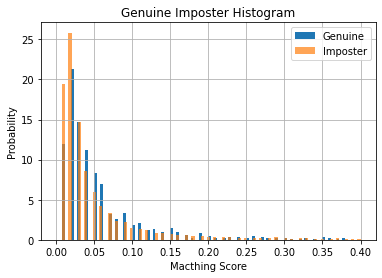

threshold is 0.03003003003003003
CRR is 59.626% at threshold 0.030
EER is 43.957% at threshold 0.030
Accuracy is 56.043% at threshold 0.030


56.042529961609276

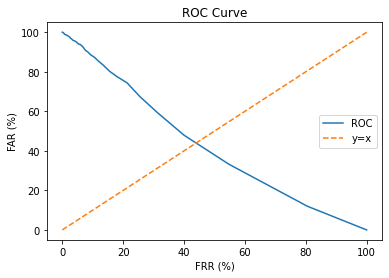

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/clahe_surf.txt"

genuine, imposter = generate_genuine_imposter(file1_path, min_score=1e-2, max_score=0.4)

print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'clahe_surf')
far, frr, threshold = plot_ROC(genuine, imposter, 'clahe_surf')
get_CRR(genuine, imposter, threshold, 'clahe_surf')
get_EER(far,frr,threshold, 'clahe_surf')
get_Acurracy(far,frr,threshold, 'clahe_surf')

### ARC FACE
https://pypi.org/project/arcface/ was used for this project.

In [ ]:
!pip install arcface

from arcface import ArcFace

     |████████████████████████████████| 62 kB 711 kB/s 
     |████████████████████████████████| 49.9 MB 17 kB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have

In [ ]:
def get_frr_far(genuine, imposter, threshold):
    # The matching scores are inversely proportional to how good the match is.
    far = len([x for x in imposter if x < threshold])/len(imposter)
    frr = len([x for x in genuine if x > threshold])/len(genuine)
    return far*100, frr*100 # rate in %


In [ ]:
import arcface
from tqdm import tqdm
from arcface import ArcFace

face = ArcFace.ArcFace()

def get_arcface_score(img1, img2):
    emb1 = face.calc_emb(img1)
    emb2 = face.calc_emb(img2)
    return face.get_distance_embeddings(emb1, emb2)

file1 = open("/home/srujan/BITS/DL/Class_Project/arcface.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

for image1 in tqdm(natsorted(os.listdir(path1))):
    img1 = os.path.join(path1, image1)
    #print(img1)
    for image2 in natsorted(os.listdir(path1)):
        if (image1 == image2):
            continue
        if image1.split("_")[2] == image2.split("_")[2]:
            continue
           
        img2 = os.path.join(path1, image2)
        # print(img1, img2)
        score = get_arcface_score(img1, img2)

        file1.write( image1 + " " + image2 + " " + str(score)+"\n")
        # print(str1, str2)

file1.close()

opening file
starting matching process


100%|██████████| 336/336 [2:30:42<00:00, 26.91s/it]


2016  is genuine length
54432  is imposter lenght


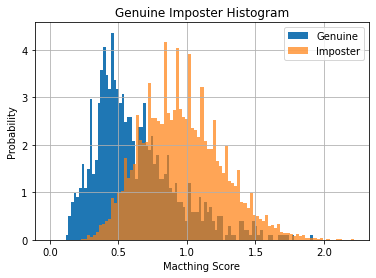

threshold is 0.7607607607607607
CRR is 26.382% at threshold 0.761
EER is 26.003% at threshold 0.761
Accuracy is 73.997% at threshold 0.761


73.99691358024691

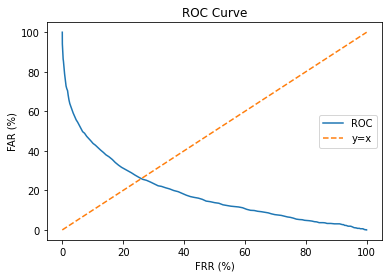

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/arcface.txt"

genuine, imposter = generate_genuine_imposter(file1_path)

print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'arcface')
far, frr, threshold = plot_ROC(genuine, imposter, 'arcface')
get_CRR(genuine, imposter, threshold, 'arcface')
get_EER(far,frr,threshold, 'arcface')
get_Acurracy(far,frr,threshold, 'arcface')

CLAHE ARC FACE

In [ ]:
import arcface
from tqdm import tqdm
from arcface import ArcFace

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
face = ArcFace.ArcFace()

def get_score(img1, img2):
    emb1 = face.calc_emb(img1)
    emb2 = face.calc_emb(img2)
    return face.get_distance_embeddings(emb1, emb2)

file1 = open("/home/srujan/BITS/DL/Class_Project/clahe_arcface.txt", 'w')
path1 = "/home/srujan/BITS/DL/Class_Project/foreheadData"

for image1 in tqdm(natsorted(os.listdir(path1))):
    img1 = os.path.join(path1, image1)
    img1 = cv2.imread(img1)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img1 = clahe.apply(img1)

    #print(img1)
    for image2 in natsorted(os.listdir(path1)):
        if (image1 == image2):
            continue
        if image1.split("_")[2] == image2.split("_")[2]:
            continue
           
        img2 = os.path.join(path1, image2)
        
        img2 = cv2.imread(img2)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = clahe.apply(img2)
        # print(img1, img2)
        score = get_score(img1, img2)

        file1.write( image1 + " " + image2 + " " + str(score)+"\n")
        # print(str1, str2)

file1.close()

1248  is genuine length
33712  is imposter lenght


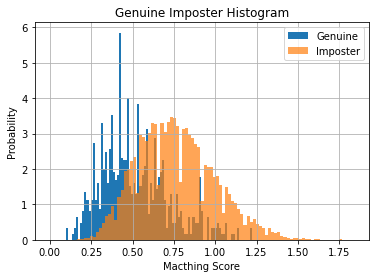

threshold is 0.6106106106106106
CRR is 28.410% at threshold 0.611
EER is 28.465% at threshold 0.611
Accuracy is 71.535% at threshold 0.611


71.53452167987052

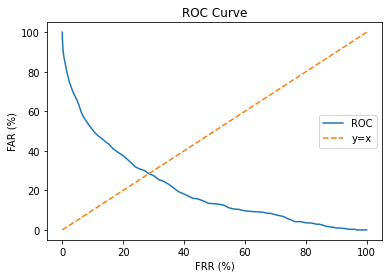

In [ ]:
file1_path = "/home/srujan/BITS/DL/Class_Project/clahe_arcface.txt"

genuine, imposter = generate_genuine_imposter(file1_path)

print(len(genuine), ' is genuine length')
print(len(imposter), ' is imposter lenght')

gen_freq, imp_freq = return_dict_from_lists(genuine, imposter)

plot_hist_from_dict(gen_freq, imp_freq, 'clahe_arcface')
far, frr, threshold = plot_ROC(genuine, imposter, 'clahe_arcface')
get_CRR(genuine, imposter, threshold, 'clahe_arcface')
get_EER(far,frr,threshold, 'clahe_arcface')
get_Acurracy(far,frr,threshold, 'clahe_arcface')